In [34]:
import torch
from torch.utils.data import Dataset,DataLoader
from torchvision import transforms
import torch.nn as nn
import torch.optim as optim
from PIL import Image
import os
import matplotlib.pyplot as plt

In [ ]:
#Dataset and Dataloader
class SARDataset(Dataset):
    def __init__(self, sar_dir, opt_dir, transform=None):
        self.sar_dir=sar_dir
        self.opt_dir=opt_dir
        self.transform=transform

        self.sar_images=sorted(os.listdir(sar_dir))
        self.opt_images=sorted(os.listdir(opt_dir))

        if len(self.sar_images) != len(self.opt_images):
            raise ValueError("The number of SAR and optical images must be the same.")

    def __len__(self):
        return len(self.sar_images)
    
    def __getitem__(self, idx):
        sar_image_path=os.path.join(self.sar_dir,self.sar_images[idx])
        opt_image_path=os.path.join(self.opt_dir,self.opt_images[idx])

        sar_image=Image.open(sar_image_path).convert("RGB")
        opt_image=Image.open(opt_image_path).convert("RGB")

        if self.transform:
            sar_image=self.transform(sar_image)
            opt_image=self.transform(opt_image)

        return sar_image,opt_image
    
#transformations
transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
    #No need to calculate mean of image as it is done to match tanh output in GAN
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

In [36]:
#Load data
sar_dir = "../data/SAR"
opt_dir = "../data/OPT"
sar_val_dir = "../data/SAR1"
opt_val_dir = "../data/OPT1"

dataset = SARDataset(sar_dir, opt_dir, transform=transform)
dataloader = DataLoader(dataset, batch_size=16, shuffle=True)
val_dataset = SARDataset(sar_val_dir, opt_val_dir, transform=transform)
val_dataloader = DataLoader(val_dataset, batch_size=16, shuffle=False)


In [37]:
for sar, opt in dataloader:
    print("SAR batch:", sar.shape)   # [16, 3, 256, 256]
    print("OPT batch:", opt.shape)   # [16, 3, 256, 256]
    break

for sar, opt in val_dataloader:
    print("Validation SAR batch:", sar.shape)   # [16, 3, 256, 256]
    print("Validation OPT batch:", opt.shape)   # [16, 3, 256, 256]
    break


SAR batch: torch.Size([16, 3, 256, 256])
OPT batch: torch.Size([16, 3, 256, 256])
Validation SAR batch: torch.Size([16, 3, 256, 256])
Validation OPT batch: torch.Size([16, 3, 256, 256])


In [38]:
#Generator

#Block
class Block(nn.Module):
    def __init__(self, in_channels, out_channels, down=True, act="relu", use_dropout=False):
        super().__init__()

        #Downsampling code

        if down:
            self.block = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=4, stride=2, padding=1, padding_mode="reflect"),
                nn.BatchNorm2d(out_channels),
                nn.LeakyReLU(0.2) if act=="leaky" else nn.ReLU()
            )

        #Upsampling code

        else: 
            self.block = nn.Sequential(
                nn.ConvTranspose2d(in_channels, out_channels, kernel_size=4, stride=2, padding=1),
                nn.BatchNorm2d(out_channels),
                nn.Dropout(0.5) if use_dropout else nn.Identity(),
                nn.ReLU()
            )
    def forward(self, x):
        return self.block(x)
    
#UNet Model for Generator
class Generator(nn.Module):
    def __init__(self, in_channels=3, features=64):
        super().__init__()
        self.initial_down = nn.Sequential(
            nn.Conv2d(in_channels, features, kernel_size=4, stride=2, padding=1, padding_mode="reflect"), # 128x128
            nn.LeakyReLU(0.2)
        )

        #Encoder
        self.down1 = Block(features, features*2, down=True, act="leaky", use_dropout=False) # 64*64
        self.down2 = Block(features*2, features*4, down=True, act="leaky", use_dropout=False) # 32*32
        self.down3 = Block(features*4, features*8, down=True, act="leaky", use_dropout=False) # 16*16
        self.down4 = Block(features*8, features*8, down=True, act="leaky", use_dropout=False) # 8*8
        self.down5 = Block(features*8, features*8, down=True, act="leaky", use_dropout=False) # 4*4
        self.down6 = Block(features*8, features*8, down=True, act="leaky", use_dropout=False) # 2*2

        #bottleneck
        self.bottleneck = nn.Sequential(
            nn.Conv2d(features*8, features*8, kernel_size=4, stride=2, padding=1, padding_mode="reflect"), #1x1
            nn.ReLU()
        )

        #decoder
        self.up1 = Block(features*8, features*8, down=False, act="relu", use_dropout=True) #2x2
        self.up2 = Block(features*8*2, features*8, down=False, act="relu", use_dropout=True) #4x4
        self.up3 = Block(features*8*2, features*8, down=False, act="relu", use_dropout=True) #8x8
        self.up4 = Block(features*8*2, features*8, down=False, act="relu", use_dropout=False) #16x16
        self.up5 = Block(features*8*2, features*4, down=False, act="relu", use_dropout=False) #32x32
        self.up6 = Block(features*4*2, features*2, down=False, act="relu", use_dropout=False) #64x64
        self.up7 = Block(features*2*2, features, down=False, act="relu", use_dropout=False) #128x128

        self.final_up = nn.Sequential(
            nn.ConvTranspose2d(features*2, in_channels, kernel_size=4, stride=2, padding=1),
            nn.Tanh()
        )

    def forward(self,x):
            d1 = self.initial_down(x)
            d2 = self.down1(d1)
            d3 = self.down2(d2)
            d4 = self.down3(d3)
            d5 = self.down4(d4)
            d6 = self.down5(d5)
            d7 = self.down6(d6)
            
            bottleneck = self.bottleneck(d7)
            
            up1 = self.up1(bottleneck)
            up2 = self.up2(torch.cat([up1, d7], 1))
            up3 = self.up3(torch.cat([up2, d6], 1))
            up4 = self.up4(torch.cat([up3, d5], 1))
            up5 = self.up5(torch.cat([up4, d4], 1))
            up6 = self.up6(torch.cat([up5, d3], 1))
            up7 = self.up7(torch.cat([up6, d2], 1))
            
            return self.final_up(torch.cat([up7, d1],1))


In [39]:
#Convolution block
class CNN_Block(nn.Module):
    def __init__(self,in_channels,out_channels,stride=2):
        super().__init__()
        self.conv = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, 4, stride, bias=False, padding_mode="reflect"),
                nn.BatchNorm2d(out_channels),
                nn.LeakyReLU(0.2)
            )
    def forward(self, x):
        return self.conv(x)

In [40]:
# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

Using device: cuda


In [41]:
class Discriminator(nn.Module):
    def __init__(self, in_channels=3, features=[64, 128, 256, 512]):
        super().__init__()
        self.initial=nn.Sequential(
            nn.Conv2d(in_channels*2, features[0], kernel_size=4, stride=2, padding=1, padding_mode="reflect"),
            nn.LeakyReLU(0.2)
        )
        layers=[]
        in_channels=features[0]
        for feature in features[1:]:
            layers.append(CNN_Block(in_channels,feature,stride=1 if feature==features[-1] else 2))
            in_channels=feature
        layers.append(
            nn.Conv2d(in_channels,1,kernel_size=4,stride=1,padding=1,padding_mode="reflect")
        )
        self.model=nn.Sequential(*layers)

    def forward(self,x,y):
            x=torch.cat([x,y],dim=1)
            x=self.initial(x)
            return self.model(x)

In [42]:
#Training preparation

netD = Discriminator().to(device)
netG = Generator().to(device)
lr=2e-4
beta1=0.5
optimizerD = optim.Adam(netD.parameters(), lr=lr, betas=(beta1, 0.999))
OptimizerG = optim.Adam(netG.parameters(), lr=lr, betas=(beta1, 0.999))
schedulerG = optim.lr_scheduler.StepLR(OptimizerG, step_size=20, gamma=0.5)
schedulerD = optim.lr_scheduler.StepLR(optimizerD, step_size=20, gamma=0.5)
criterion = nn.BCEWithLogitsLoss()
L1_loss = nn.L1Loss()


In [43]:
def show_sample(sar, fake_opt, opt, idx=0):
    """
    Displays one sample from the batch: SAR input, Generated Optical, Real Optical
    """
    # Undo normalization from [-1,1] to [0,1]
    sar_img = (sar[idx] + 1) / 2
    fake_img = (fake_opt[idx] + 1) / 2
    opt_img = (opt[idx] + 1) / 2

    fig, axes = plt.subplots(1, 3, figsize=(12, 4))
    
    axes[0].imshow(sar_img.permute(1,2,0).detach().cpu())
    axes[0].set_title("SAR Input")
    axes[0].axis('off')

    axes[1].imshow(fake_img.permute(1,2,0).detach().cpu())
    axes[1].set_title("Generated Optical")
    axes[1].axis('off')

    axes[2].imshow(opt_img.permute(1,2,0).detach().cpu())
    axes[2].set_title("Real Optical")
    axes[2].axis('off')

    plt.show()


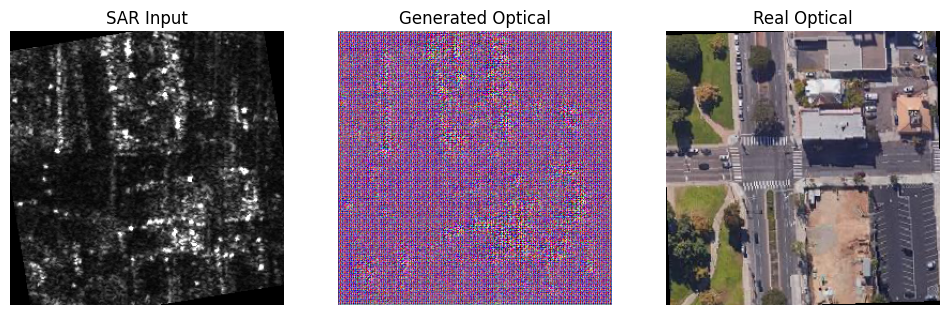

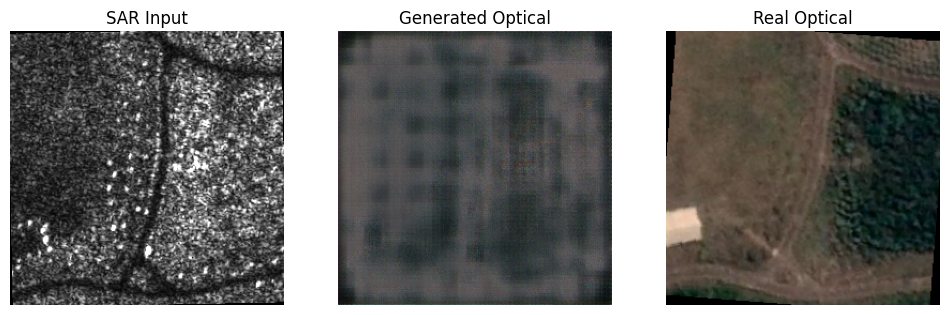

Epoch [1/100]  Train Loss: 33.3538  Val Loss: 39.2568


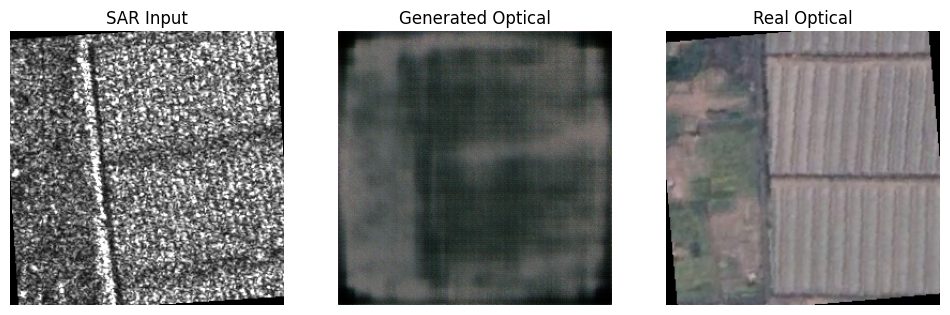

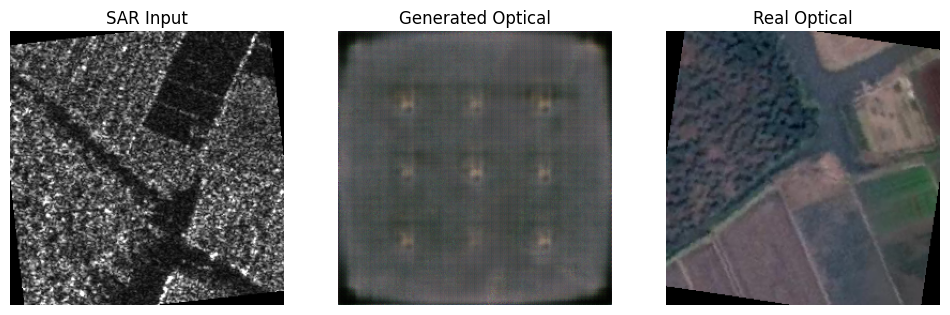

KeyboardInterrupt: 

In [44]:
#Training
num_epochs = 100
train_losses = []
val_losses = []

for epoch in range(num_epochs):
    netG.train()
    netD.train()
    epoch_train_loss = 0.0

    #Training loop
    for batch_idx, (sar, opt) in enumerate(dataloader):
        sar,opt=sar.to(device),opt.to(device)

        #Train Discriminator first

        fake_opt =netG(sar)
        D_real = netD(sar,opt)
        D_fake= netD(sar,fake_opt.detach()) # detach to avoid backprop to generator
        
        real_loss = criterion(D_real, torch.ones_like(D_real))
        fake_loss = criterion(D_fake, torch.zeros_like(D_fake))
        D_loss = (real_loss + fake_loss) / 2

        optimizerD.zero_grad()
        D_loss.backward()
        optimizerD.step()

        #Train Generator
        D_fake = netD(sar, fake_opt)
        G_fake_loss = criterion(D_fake, torch.ones_like(D_fake))
        L1=L1_loss(fake_opt, opt)*100
        G_loss = G_fake_loss + L1

        OptimizerG.zero_grad()
        G_loss.backward()
        OptimizerG.step()

        epoch_train_loss += G_loss.item()

        if batch_idx %500 == 0:
            show_sample(sar, fake_opt, opt, idx=0)

    avg_train_loss = epoch_train_loss / len(dataloader)
    train_losses.append(avg_train_loss)
    schedulerG.step()
    schedulerD.step()

    #validation loop
    netG.eval()
    epoch_val_loss = 0.0

    with torch.no_grad():
        for sar, opt in val_dataloader:
            sar,opt=sar.to(device),opt.to(device)
            fake_opt = netG(sar)
            D_fake = netD(sar, fake_opt)
            G_fake_loss = criterion(D_fake, torch.ones_like(D_fake))
            L1 = L1_loss(fake_opt, opt) * 100
            G_loss = G_fake_loss + L1
            epoch_val_loss += G_loss.item()
        
    avg_val_loss = epoch_val_loss / len(val_dataloader)
    val_losses.append(avg_val_loss)

    print(f"Epoch [{epoch+1}/{num_epochs}]  Train Loss: {avg_train_loss:.4f}  Val Loss: {avg_val_loss:.4f}")






In [ ]:
# Save the models
torch.save(netG.state_dict(), "../model/generator.pth")
torch.save(netD.state_dict(), "../model/discriminator.pth")